# 時系列特徴量自動生成の、tsfreshを試す
https://qiita.com/KI1208/items/e27f827bac8654c9adcc

In [1]:
!pip install tsfresh

     |████████████████████████████████| 91 kB 4.0 MB/s 
     |████████████████████████████████| 900 kB 4.8 MB/s 
     |████████████████████████████████| 675 kB 9.2 MB/s 
  Attempting uninstall: tblib
    Found existing installation: tblib 1.4.0
    Uninstalling tblib-1.4.0:
      Successfully uninstalled tblib-1.4.0
  Attempting uninstall: dask
    Found existing installation: dask 2.5.2
    Uninstalling dask-2.5.2:
      Successfully uninstalled dask-2.5.2
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.2.2
    Uninstalling cloudpickle-1.2.2:
      Successfully uninstalled cloudpickle-1.2.2
  Attempting uninstall: distributed
    Found existing installation: distributed 2.5.2
    Uninstalling distributed-2.5.2:
      Successfully uninstalled distributed-2.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 3.3.6 requir

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

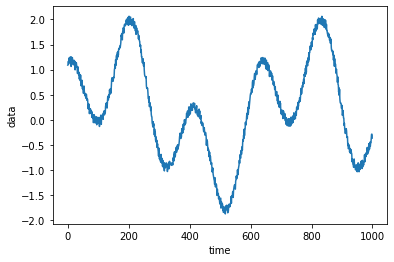

In [4]:
timeline = np.arange(10000)

data = np.sin(timeline/100) + np.cos((timeline/100) * 3) + (np.random.rand(len(timeline)))*0.2

plt.plot(timeline[:1000], data[:1000])
plt.xlabel('time')
plt.ylabel('data')
plt.show()

In [5]:
import tsfresh.feature_extraction.feature_calculators as feature_calculators

range_data = data[:600]


mean_abs_change = feature_calculators.mean_abs_change(data)
# 前後のポイント間での差分の平均値
# np.mean(np.abs(np.diff(x))) と等しい

first_location_of_maximum = feature_calculators.first_location_of_maximum(data)
# 最大値が観測される位置

fft_aggregated = feature_calculators.fft_aggregated(data, [{'aggtype': 'skew'}])
# フーリエ変換

number_peaks = feature_calculators.number_peaks(data[:1000], 50)
# ピークの数

index_mass_quantile = feature_calculators.index_mass_quantile(data[:1000], [{'q': 0.5},{'q': 0.1}])
# パーセンタイル処理

linear_trend = feature_calculators.linear_trend(range_data, [{'attr': "slope"},{'attr': 'intercept'},{'attr': 'rvalue'}])
# 単純なトレンド分析。attrに関しては下記を参照
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

autocorrelation = feature_calculators.autocorrelation(data, 100)
# 自己相関の計算

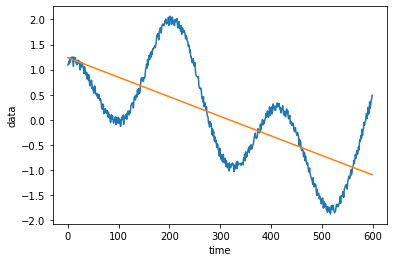

In [6]:
trend = linear_trend[0][1] * timeline + linear_trend[1][1]

plt.plot(timeline[:600], data[:600])
plt.plot(timeline[:600], trend[:600])
plt.xlabel('time')
plt.ylabel('data')
plt.show()

In [7]:
from tsfresh import extract_features

# こちらはDataFrameではないといけないようなので変換する。
# 1つのデータフレーム内に複数の時系列データがある形を想定しているらしく、どのデータが時系列としてひとまとまりなのか識別するカラムが必要(column_idで指定)
# 今回は1種類しか入っていないので、すべて1にした
temp = pd.DataFrame(data, columns=['value'], dtype='float')

temp['id'] = 1
temp.head()

extracted_features = extract_features(temp, column_id='id')
display(extracted_features.columns)

Feature Extraction: 100%|██████████| 1/1 [01:30<00:00, 90.52s/it]


Index(['value__variance_larger_than_standard_deviation',
       'value__has_duplicate_max', 'value__has_duplicate_min',
       'value__has_duplicate', 'value__sum_values', 'value__abs_energy',
       'value__mean_abs_change', 'value__mean_change',
       'value__mean_second_derivative_central', 'value__median',
       ...
       'value__fourier_entropy__bins_2', 'value__fourier_entropy__bins_3',
       'value__fourier_entropy__bins_5', 'value__fourier_entropy__bins_10',
       'value__fourier_entropy__bins_100',
       'value__permutation_entropy__dimension_3__tau_1',
       'value__permutation_entropy__dimension_4__tau_1',
       'value__permutation_entropy__dimension_5__tau_1',
       'value__permutation_entropy__dimension_6__tau_1',
       'value__permutation_entropy__dimension_7__tau_1'],
      dtype='object', length=779)

### 779の特徴量が生成されたことがわかる